In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib


np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

###########

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt

from scipy.stats import gaussian_kde # for density plot

from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import StrMethodFormatter

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib.ticker import FormatStrFormatter

C:\Users\user\AppData\Local\Temp\ipykernel_12424\2582283010.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


C:\Users\user\AppData\Local\Temp\ipykernel_12424\1572292671.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto1 = get_problem("zdt1").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_12424\1572292671.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto2 = get_problem("zdt2").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_12424\1572292671.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto3 = get_problem("zdt3").pareto_front()


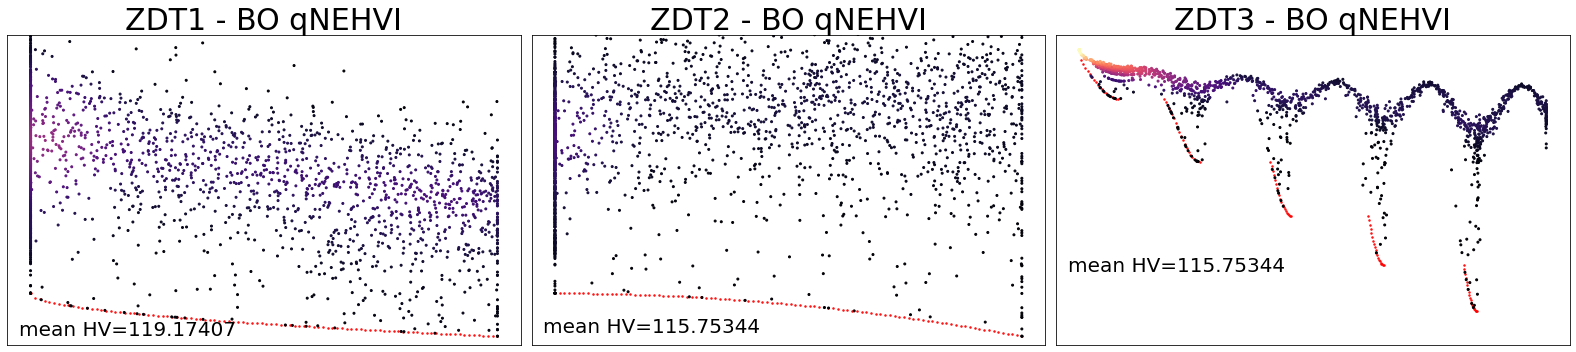

In [12]:
pareto1 = get_problem("zdt1").pareto_front()
pareto2 = get_problem("zdt2").pareto_front()
pareto3 = get_problem("zdt3").pareto_front()

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

fig, ax = plt.subplots(ncols = 3, nrows=1, figsize = (22,5))

for problemname, pareto, i in zip(['ZDT1', 'ZDT2', 'ZDT3'], [pareto1, pareto2, pareto3], [0, 1, 2]):

    train_qnehvi_all0 = loadtxt(f"{problemname}_train_qnehvi_24by8.csv", delimiter=',').reshape(10, 210, 10)
    train_nsga3_all0 = loadtxt(f"{problemname}_train_nsga3_24by8.csv", delimiter=',').reshape(10, 210, 10)

    train = train_qnehvi_all0

    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,8:10][:,0])
        ylist.append(-train[trial][:,8:10][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    train = train_nsga3_all0

    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,8:10][:,0])
        ylist.append(-train[trial][:,8:10][:,1])

    x1 = np.array(xlist).reshape(-1)
    y1 = np.array(ylist).reshape(-1)
    xy1 = np.vstack([x1,y1])
    z1 = gaussian_kde(xy1)(xy1)
    idx1 = z1.argsort()
    x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

    norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)

    ax[i].scatter(x, y, c=z, s=4, norm=norm, cmap='magma')

    
    ax[i].set_title(f"{problemname} - BO qNEHVI", fontsize=30)
    
    ax[i].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
    ax[i].tick_params(left=False, bottom=False)

ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(-0.2, 7)
    
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.2, 7.0)

ax[2].set_xlim(-0.05, 1.05)
ax[2].set_ylim(-1.0, 1.1)


hvs = loadtxt(f"ZDT1_hvs_qnehvi_24by8.csv", delimiter=',')
ax[0].text(-0.025, 0.025,
           f"mean HV={np.array(hvs).mean(axis=0)[-1]:.5f}",
           fontsize=20)

hvs = loadtxt(f"ZDT2_hvs_qnehvi_24by8.csv", delimiter=',')
ax[1].text(-0.025, 0.1,
           f"mean HV={np.array(hvs).mean(axis=0)[-1]:.5f}",
           fontsize=20)

hvs = loadtxt(f"ZDT2_hvs_qnehvi_24by8.csv", delimiter=',')
ax[2].text(-0.025, -0.5,
           f"mean HV={np.array(hvs).mean(axis=0)[-1]:.5f}",
           fontsize=20)

fig.tight_layout()

C:\Users\user\AppData\Local\Temp\ipykernel_12424\1444820061.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto1 = get_problem("zdt1").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_12424\1444820061.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto2 = get_problem("zdt2").pareto_front()
C:\Users\user\AppData\Local\Temp\ipykernel_12424\1444820061.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  pareto3 = get_problem("zdt3").pareto_front()


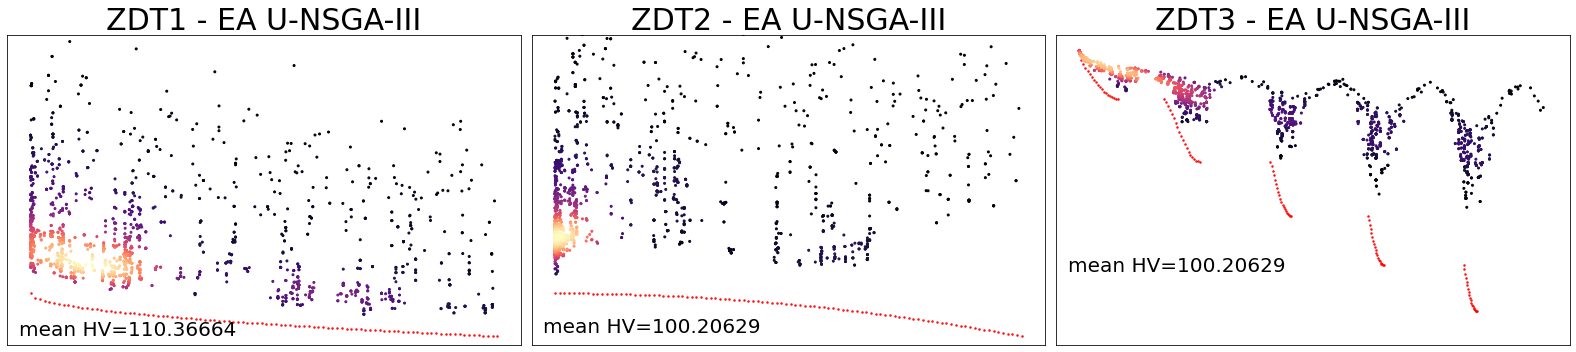

In [16]:
pareto1 = get_problem("zdt1").pareto_front()
pareto2 = get_problem("zdt2").pareto_front()
pareto3 = get_problem("zdt3").pareto_front()

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

fig, ax = plt.subplots(ncols = 3, nrows=1, figsize = (22,5))

for problemname, pareto, i in zip(['ZDT1', 'ZDT2', 'ZDT3'], [pareto1, pareto2, pareto3], [0, 1, 2]):

    train_qnehvi_all0 = loadtxt(f"{problemname}_train_qnehvi_24by8.csv", delimiter=',').reshape(10, 210, 10)
    train_nsga3_all0 = loadtxt(f"{problemname}_train_nsga3_24by8.csv", delimiter=',').reshape(10, 210, 10)

    train = train_qnehvi_all0

    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,8:10][:,0])
        ylist.append(-train[trial][:,8:10][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    train = train_nsga3_all0

    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,8:10][:,0])
        ylist.append(-train[trial][:,8:10][:,1])

    x1 = np.array(xlist).reshape(-1)
    y1 = np.array(ylist).reshape(-1)
    xy1 = np.vstack([x1,y1])
    z1 = gaussian_kde(xy1)(xy1)
    idx1 = z1.argsort()
    x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

    norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)

    ax[i].scatter(x1, y1, c=z1, s=4, norm=norm, cmap='magma')

    
    ax[i].set_title(f"{problemname} - EA U-NSGA-III", fontsize=30)
    
    ax[i].set(ylabel=None, yticklabels=[], xlabel=None, xticklabels=[])
    ax[i].tick_params(left=False, bottom=False)

ax[0].set_xlim(-0.05, 1.05)
ax[0].set_ylim(-0.2, 7)
    
ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.2, 7.0)

ax[2].set_xlim(-0.05, 1.05)
ax[2].set_ylim(-1.0, 1.1)


hvs = loadtxt(f"ZDT1_hvs_nsga3_24by8.csv", delimiter=',')
ax[0].text(-0.025, 0.025,
           f"mean HV={np.array(hvs).mean(axis=0)[-1]:.5f}",
           fontsize=20)

hvs = loadtxt(f"ZDT2_hvs_nsga3_24by8.csv", delimiter=',')
ax[1].text(-0.025, 0.1,
           f"mean HV={np.array(hvs).mean(axis=0)[-1]:.5f}",
           fontsize=20)

hvs = loadtxt(f"ZDT2_hvs_nsga3_24by8.csv", delimiter=',')
ax[2].text(-0.025, -0.5,
           f"mean HV={np.array(hvs).mean(axis=0)[-1]:.5f}",
           fontsize=20)

fig.tight_layout()

C:\Users\user\AppData\Local\Temp\ipykernel_75176\2896560269.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt1")


Text(0.5, 1.0, 'PDF')

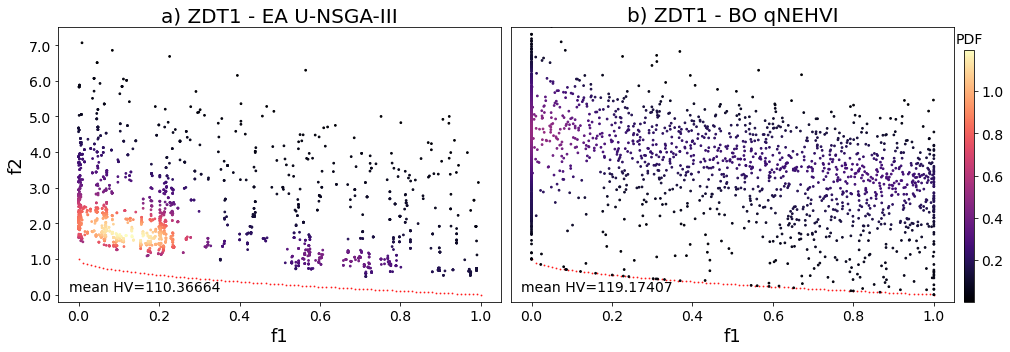

In [8]:
algos = ['EA U-NSGA-III', 'BO qNEHVI']
letter = ['a', 'b']

problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

train_qnehvi_all0 = loadtxt("ZDT1_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(10, 210, 10)
train_nsga3_all0 = loadtxt("ZDT1_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(10, 210, 10)

hvs_qnehvi_all0 = loadtxt("ZDT1_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("ZDT1_hvs_nsga3_24by8.csv", delimiter=',')

train = train_qnehvi_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x = np.array(xlist).reshape(-1)
y = np.array(ylist).reshape(-1)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

train = train_nsga3_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x1 = np.array(xlist).reshape(-1)
y1 = np.array(ylist).reshape(-1)
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)
idx1 = z1.argsort()
x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))


ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[0].scatter(x1, y1, c=z1, s=3, norm=norm, cmap='magma')

ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[1].scatter(x, y, c=z, s=3, norm=norm, cmap='magma')


for i, train in enumerate((train_nsga3_all0, train_qnehvi_all0)):
    ax[i].set_title(f"{letter[i]}) ZDT1 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.2, 7.5)
    
ax[0].set_ylabel('f2')



ax[0].text(-0.025, 0.1, f"mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}", fontsize=14)
ax[1].text(-0.025, 0.1, f"mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}", fontsize=14)

ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

#fig.savefig('ZDT1_prob.pdf')


C:\Users\user\AppData\Local\Temp\ipykernel_75176\496139811.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt2")


Text(0.5, 1.0, 'PDF')

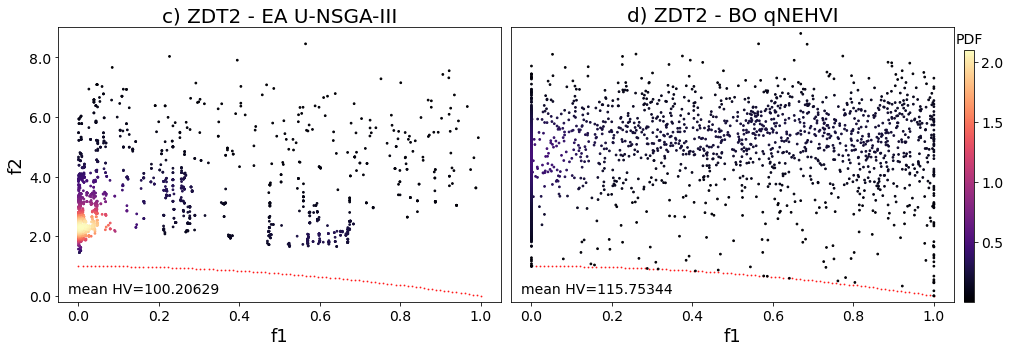

In [9]:
algos = ['EA U-NSGA-III', 'BO qNEHVI']
letter = ['c', 'd']
problem1 = get_problem("zdt2")
pareto = problem1.pareto_front()

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

train_qnehvi_all0 = loadtxt("ZDT2_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(10, 210, 10)
train_nsga3_all0 = loadtxt("ZDT2_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(10, 210, 10)

hvs_qnehvi_all0 = loadtxt("ZDT2_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("ZDT2_hvs_nsga3_24by8.csv", delimiter=',')

train = train_qnehvi_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x = np.array(xlist).reshape(-1)
y = np.array(ylist).reshape(-1)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

train = train_nsga3_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x1 = np.array(xlist).reshape(-1)
y1 = np.array(ylist).reshape(-1)
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)
idx1 = z1.argsort()
x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))


ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[0].scatter(x1, y1, c=z1, s=3, norm=norm, cmap='magma')

ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[1].scatter(x, y, c=z, s=3, norm=norm, cmap='magma')


for i, train in enumerate((train_nsga3_all0, train_qnehvi_all0)):
    ax[i].set_title(f"{letter[i]}) ZDT2 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.2, 9.0)
    
ax[0].set_ylabel('f2')

ax[0].text(-0.025, 0.1, f"mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}", fontsize=14)
ax[1].text(-0.025, 0.1, f"mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}", fontsize=14)

ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

C:\Users\user\AppData\Local\Temp\ipykernel_75176\39515798.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("zdt3")


Text(0.5, 1.0, 'PDF')

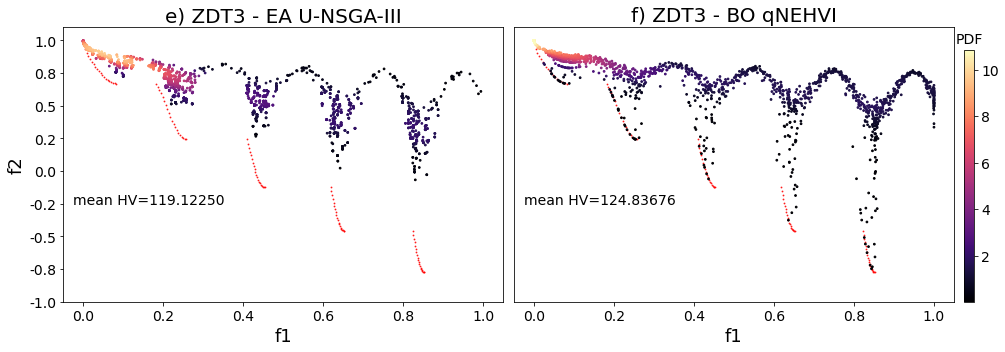

In [10]:
algos = ['EA U-NSGA-III', 'BO qNEHVI']
letter = ['e', 'f']

problem1 = get_problem("zdt3")
pareto = problem1.pareto_front()

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

train_qnehvi_all0 = loadtxt("ZDT3_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(10, 210, 10)
train_nsga3_all0 = loadtxt("ZDT3_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(10, 210, 10)

hvs_qnehvi_all0 = loadtxt("ZDT3_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("ZDT3_hvs_nsga3_24by8.csv", delimiter=',')

train = train_qnehvi_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x = np.array(xlist).reshape(-1)
y = np.array(ylist).reshape(-1)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

train = train_nsga3_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x1 = np.array(xlist).reshape(-1)
y1 = np.array(ylist).reshape(-1)
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)
idx1 = z1.argsort()
x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))


ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[0].scatter(x1, y1, c=z1, s=3, norm=norm, cmap='magma')

ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[1].scatter(x, y, c=z, s=3, norm=norm, cmap='magma')


for i, train in enumerate((train_nsga3_all0, train_qnehvi_all0)):
    ax[i].set_title(f"{letter[i]}) ZDT3 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-1.0, 1.1)
    
ax[0].set_ylabel('f2')

ax[0].text(-0.025, -0.25, f"mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}", fontsize=14)
ax[1].text(-0.025, -0.25, f"mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}", fontsize=14)

ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

C:\Users\user\AppData\Local\Temp\ipykernel_75176\4212247984.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) get_problem. (Please use `from pymoo.problems import get_problem
`)
  problem1 = get_problem("mw7")


Text(0.5, 1.0, 'PDF')

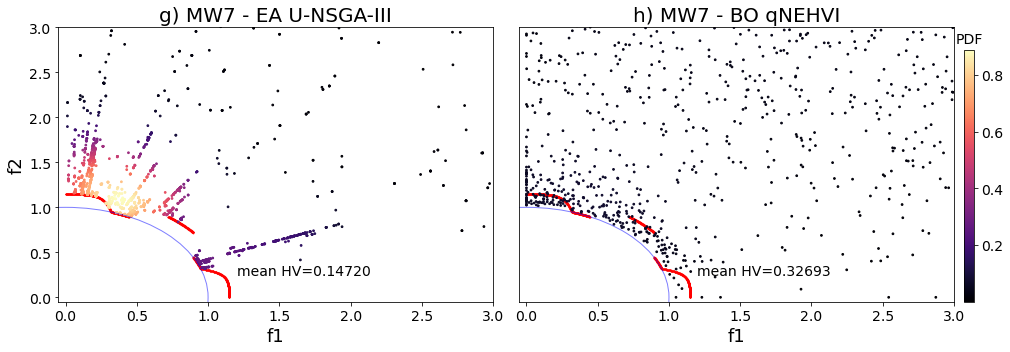

In [12]:
algos = ['EA U-NSGA-III', 'BO qNEHVI']
letter = ['g', 'h']

problem1 = get_problem("mw7")
pareto = problem1.pareto_front()

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

train_qnehvi_all0 = loadtxt("old_MW7_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(10, 210, 12)
train_nsga3_all0 = loadtxt("old_MW7_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(10, 210, 12)

hvs_qnehvi_all0 = loadtxt("old_MW7_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("old_MW7_hvs_nsga3_24by8.csv", delimiter=',')

train = train_qnehvi_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x = np.array(xlist).reshape(-1)
y = np.array(ylist).reshape(-1)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

train = train_nsga3_all0

xlist, ylist = [], []

for trial in range(N_TRIALS):

    xlist.append(-train[trial][:,8:10][:,0])
    ylist.append(-train[trial][:,8:10][:,1])

x1 = np.array(xlist).reshape(-1)
y1 = np.array(ylist).reshape(-1)
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)
idx1 = z1.argsort()
x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))


ax[0].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[0].scatter(x1, y1, c=z1, s=3, norm=norm, cmap='magma')

ax[1].scatter(pareto[:,0],
              pareto[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

ax[1].scatter(x, y, c=z, s=3, norm=norm, cmap='magma')


for i, train in enumerate((train_nsga3_all0, train_qnehvi_all0)):
    ax[i].set_title(f"{letter[i]}) MW7 - {algos[i]}", fontsize=20)
    ax[i].set_xlabel('f1')

    ax[i].set_xlim(-0.05, 3)
    ax[i].set_ylim(-0.05, 3)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, alpha=0.5))

ax[0].text(1.2, 0.25, f"mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}", fontsize=14)
ax[1].text(1.2, 0.25, f"mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}", fontsize=14)
    
ax[0].set_ylabel('f2')
#ax[1].tick_params(left = False, labelleft = False)

ax[1].set(ylabel=None, yticklabels=[])
ax[1].tick_params(left=False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

In [3]:
train_qnehvi_all0 = loadtxt("thinfilm_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(2020, 6)
train_nsga3_all0 = loadtxt("thinfilm_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(2020, 6)

hvs_qnehvi_all0 = loadtxt("thinfilm_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("thinfilm_hvs_nsga3_24by8.csv", delimiter=',')

xscaler = joblib.load('thinfilm_xscaler')
yscaler = joblib.load('thinfilm_yscaler')
    
pareto_y1 = loadtxt("thinfilm_pareto1.csv", delimiter=',')
pareto_y2 = loadtxt("thinfilm_pareto2.csv", delimiter=',')  

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
train = train_qnehvi_all0

x_true = xscaler.inverse_transform(train[...,0:4])[...,-1]
y_true = yscaler.inverse_transform(train[...,-1:]).ravel()
xy = np.vstack([x_true,y_true])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x_true[idx], y_true[idx], z[idx]

train = train_nsga3_all0

x_true1 = xscaler.inverse_transform(train[...,0:4])[...,-1]
y_true1 = yscaler.inverse_transform(train[...,-1:]).ravel()
xy1 = np.vstack([x_true1,y_true1])
z1 = gaussian_kde(xy1)(xy1)
idx1 = z1.argsort()
x1, y1, z1 = x_true1[idx1], y_true1[idx1], z1[idx1]

Text(0.5, 1.0, 'PDF')

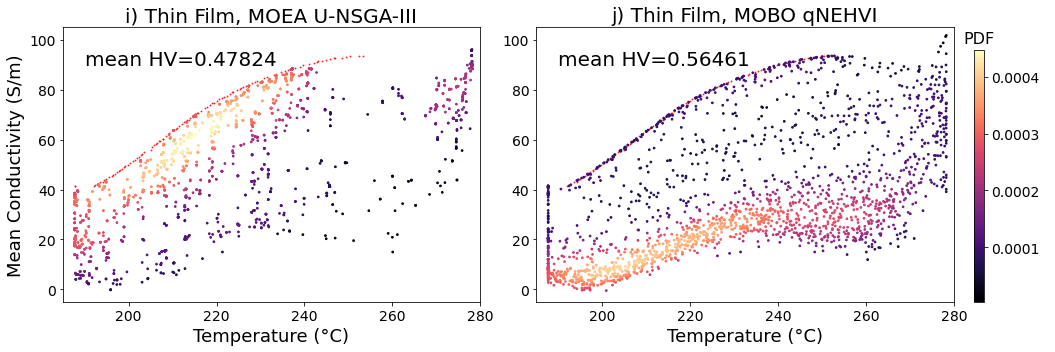

In [5]:
cmap = 'magma'
algos = ['MOEA U-NSGA-III', 'MOBO qNEHVI']

ref_point = torch.tensor([280, 6.331280245], **tkwargs)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 4
    n_obj = 2
    n_constr = 0
    
problem = Problem


N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

ax[0].scatter(pareto_y1,
              pareto_y2, 
              c="r", s=3, marker=".", alpha=0.8)

'''
ax[0].scatter(ref_point.cpu().numpy()[0],
              ref_point.cpu().numpy()[1], 
              c="r", s=100, marker="*")
'''

ax[0].scatter(x1, y1, c=z1, s=3, norm=norm, cmap='magma')

ax[1].scatter(pareto_y1,
              pareto_y2, 
              c="r", s=3, marker=".", alpha=0.8)
'''
ax[1].scatter(ref_point.cpu().numpy()[0],
              ref_point.cpu().numpy()[1], 
              c="r", s=100, marker="*")
'''
ax[1].scatter(x, y, c=z, s=3, norm=norm, cmap='magma')

for i, train, letter in zip([0,1],
                            [train_nsga3_all0, train_qnehvi_all0],
                            ['i', 'j']):    
    
    ax[i].set_title(f"{letter}) Thin Film, {algos[i]}", fontsize=20)
    
    ax[i].set_xlabel('Temperature (°C)')

    ax[i].set_xlim(185, 280)
    ax[i].set_ylim(-5, 105)
    
ax[0].set_ylabel('Mean Conductivity (S/m)')
fig.tight_layout()


ax[0].text(190, 90, f"mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}", fontsize=20)
ax[1].text(190, 90, f"mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}", fontsize=20)

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=16)

#fig.savefig('prob_thinfilm.pdf')

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


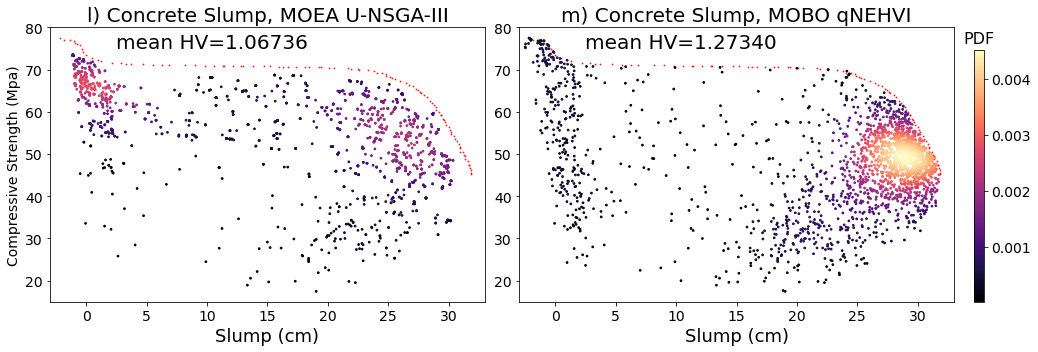

In [8]:
train_qnehvi_all0 = loadtxt("concrete_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(2080, 9)
train_nsga3_all0 = loadtxt("concrete_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(2080, 9)

hvs_qnehvi_all0 = loadtxt("concrete_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("concrete_hvs_nsga3_24by8.csv", delimiter=',')

yscaler = joblib.load('concrete_yscaler')
    
pareto_y = loadtxt("concrete_pareto.csv", delimiter=',')


train = train_qnehvi_all0

real_y = yscaler.inverse_transform(train[...][...,-2:])
xy = np.vstack([real_y[:,0],real_y[:,1]])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = real_y[:,0][idx], real_y[:,1][idx], z[idx]

train = train_nsga3_all0

real_y1 = yscaler.inverse_transform(train[...][...,-2:])
xy1 = np.vstack([real_y1[:,0],real_y1[:,1]])
z1 = gaussian_kde(xy1)(xy1)
idx1 = z1.argsort()
x1, y1, z1 = real_y1[:,0][idx1], real_y1[:,1][idx1], z1[idx1]

cmap = 'magma'
algos = ['MOEA U-NSGA-III', 'MOBO qNEHVI']

ref_point = torch.tensor([0, 0], **tkwargs)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 7
    n_obj = 2
    n_constr = 0
    
problem = Problem


N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

norm = plt.Normalize(min(z.min(),z1.min()), max(z.max(),z1.max()))

fig, ax = plt.subplots(ncols = 2, figsize = (14,5))

ax[0].scatter(pareto_y[:,0],
              pareto_y[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

'''
ax[0].scatter(ref_point.cpu().numpy()[0],
              ref_point.cpu().numpy()[1], 
              c="r", s=100, marker="*")
'''
ax[0].scatter(x1, y1, c=z1, s=3, norm=norm, cmap='magma')

ax[1].scatter(pareto_y[:,0],
              pareto_y[:,1], 
              c="r", s=3, marker=".", alpha=0.8)

'''
ax[1].scatter(ref_point.cpu().numpy()[0],
              ref_point.cpu().numpy()[1], 
              c="r", s=100, marker="*")
'''
ax[1].scatter(x, y, c=z, s=3, norm=norm, cmap='magma')

for i, train, letter in zip([0,1],
                            [train_nsga3_all0, train_qnehvi_all0],
                            ['l', 'm']):    
    
    ax[i].set_title(f"{letter}) Concrete Slump, {algos[i]}", fontsize=20)    
    ax[i].set_xlabel('Slump (cm)')

    ax[i].set_xlim(-3, 33)
    ax[i].set_ylim(15, 80)
    
ax[0].set_ylabel('Compressive Strength (Mpa)', fontsize=14)
fig.tight_layout()


ax[0].text(2.5, 75, f"mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}", fontsize=20)
ax[1].text(2.5, 75, f"mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}", fontsize=20)

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=16)

fig.savefig('prob_concrete.pdf')

In [36]:
algos = ['MOEA U-NSGA-III', 'MOBO qNEHVI']

ref_point = torch.tensor([0, 0, 0], **tkwargs)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 6
    n_obj = 3
    n_constr = 1
    
problem = Problem

yscaler = joblib.load('3Dprinting_yscaler')
    
pareto = loadtxt("3Dprinting_pareto.csv", delimiter=',')

N_TRIALS = 10
noise = 0
N_BATCH = 24
BATCH_SIZE = 8

train_qnehvi_all0 = loadtxt("3Dprinting_train_qnehvi_24by8.csv", delimiter=',')
train_qnehvi_all0 = train_qnehvi_all0.reshape(2060, 10)
train_nsga3_all0 = loadtxt("3Dprinting_train_nsga3_24by8.csv", delimiter=',')
train_nsga3_all0 = train_nsga3_all0.reshape(2060, 10)

hvs_qnehvi_all0 = loadtxt("3Dprinting_hvs_qnehvi_24by8.csv", delimiter=',')
hvs_nsga3_all0 = loadtxt("3Dprinting_hvs_nsga3_24by8.csv", delimiter=',')

In [37]:
real_obj = yscaler.inverse_transform(train_qnehvi_all0[...][...,-4:-1].reshape(2060,3))

x = real_obj[:,0]
y = real_obj[:,1]
z = real_obj[:,2]
xyz = np.vstack([x,y,z])
density = gaussian_kde(xyz)(xyz) 
idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

real_obj = yscaler.inverse_transform(train_nsga3_all0[...][...,-4:-1].reshape(2060,3))

x1 = real_obj[:,0]
y1 = real_obj[:,1]
z1 = real_obj[:,2]
xyz1 = np.vstack([x1,y1,z1])
density1 = gaussian_kde(xyz1)(xyz1) 
idx1 = density1.argsort()
x1, y1, z1, density1 = x1[idx1], y1[idx1], z1[idx1], density1[idx1]

norm = plt.Normalize(min(density.min(),density1.min()), max(density.max(),density1.max()))

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


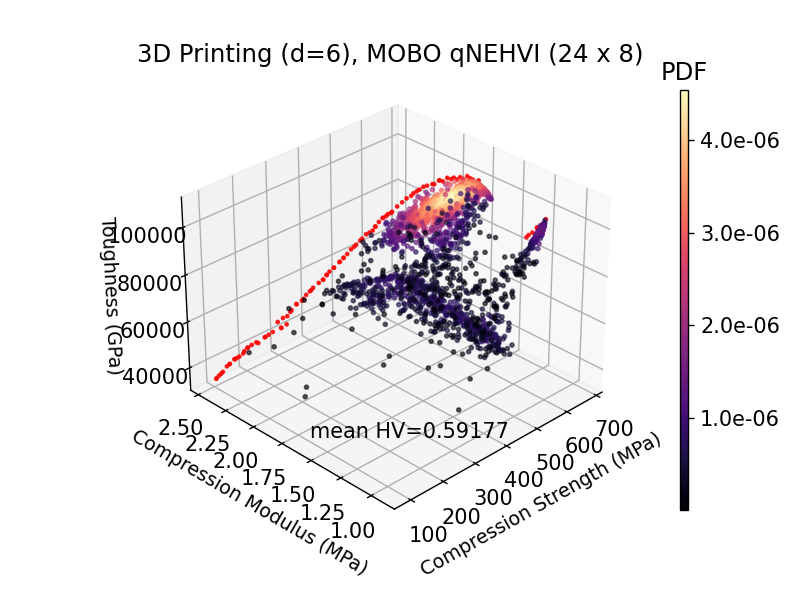

In [11]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(pareto[:,0],
             pareto[:,1],
             pareto[:,2],
            c='r', s=3, alpha=0.8)

ax.scatter3D(x,
             y,
             z,
             c=density, s=5, alpha=0.6, cmap='magma')

#for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)

ax.set_title(f"3D Printing (d=6), MOBO qNEHVI (24 x 8)", fontsize=14)
ax.set_xlabel('Compression Strength (MPa)', fontsize=11)
ax.set_ylabel('Compression Modulus (MPa)', fontsize=11)
ax.set_zlabel('Toughness (GPa)', fontsize=11)
#axes[i].set_xlim(obj1min, obj1max)
#axes[i].set_ylim(obj2min, obj2max)

ax.text(50, 1.5, 40000, s=f'mean HV={np.array(hvs_qnehvi_all0).mean(axis=0)[-1]:.5f}', fontsize=12)

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, format='%.1e')
cbar.ax.set_title("PDF", fontsize=14)

plt.show()

<IPython.core.display.Javascript object>


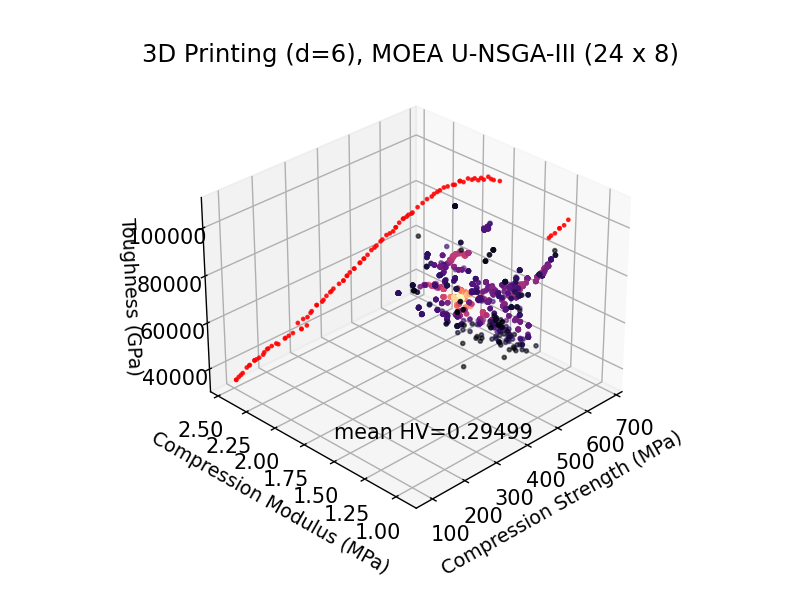

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(pareto[:,0],
             pareto[:,1],
             pareto[:,2],
            c='r', s=3, alpha=0.8)

ax.scatter3D(x1,
             y1,
             z1,
             c=density1, s=5, alpha=0.6, cmap='magma')
'''
ax.scatter3D(ref_point.cpu().numpy()[0],
             ref_point.cpu().numpy()[1], 
             ref_point.cpu().numpy()[2],
             c="r", s=100, marker="*")
'''
#for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(10)

ax.set_title(f"3D Printing (d=6), MOEA U-NSGA-III (24 x 8)", fontsize=14)
ax.set_xlabel('Compression Strength (MPa)', fontsize=11)
ax.set_ylabel('Compression Modulus (MPa)', fontsize=11)
ax.set_zlabel('Toughness (GPa)', fontsize=11)
#axes[i].set_xlim(obj1min, obj1max)
#axes[i].set_ylim(obj2min, obj2max)

ax.text(50, 1.5, 40000, s=f'mean HV={np.array(hvs_nsga3_all0).mean(axis=0)[-1]:.5f}', fontsize=12)

plt.show()

In [6]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)

trial = 1
verbose = True
noise = 0.00

problem = Problem_ZDT1


initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

###############    

hvs_qnehvi0, train_qnehvi0 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=400, BATCH_SIZE=2,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi1, train_qnehvi1 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=200, BATCH_SIZE=4,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi2, train_qnehvi2 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=100, BATCH_SIZE=8,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga30, train_nsga30 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=400, pop_size=2, ref_num=2,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga31, train_nsga31 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=200, pop_size=4, ref_num=4,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga32, train_nsga32 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=100, pop_size=8, ref_num=8,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga33, train_nsga33 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=50, pop_size=16, ref_num=16,
                                             random_state=trial, noise=noise, verbose=False)

    

savetxt("ZDT1_hvs_qnehvi_400by2.csv", hvs_qnehvi0, delimiter=',')
savetxt("ZDT1_hvs_qnehvi_200by4.csv", hvs_qnehvi1, delimiter=',')
savetxt("ZDT1_hvs_qnehvi_100by8.csv", hvs_qnehvi2, delimiter=',')

savetxt("ZDT1_hvs_nsga3_400by2.csv", hvs_nsga30, delimiter=',')
savetxt("ZDT1_hvs_nsga3_200by4.csv", hvs_nsga31, delimiter=',')
savetxt("ZDT1_hvs_nsga3_100by8.csv", hvs_nsga32, delimiter=',')    
savetxt("ZDT1_hvs_nsga3_50by16.csv", hvs_nsga33, delimiter=',')    

savetxt("ZDT1_train_qnehvi_400by2.csv", train_qnehvi0, delimiter=',')
savetxt("ZDT1_train_qnehvi_200by4.csv", train_qnehvi1, delimiter=',')
savetxt("ZDT1_train_qnehvi_100by8.csv", train_qnehvi2, delimiter=',') 

savetxt("ZDT1_train_nsga3_400by2.csv", train_nsga30, delimiter=',')
savetxt("ZDT1_train_nsga3_200by4.csv", train_nsga31, delimiter=',')
savetxt("ZDT1_train_nsga3_100by8.csv", train_nsga32, delimiter=',')   
savetxt("ZDT1_train_nsga3_50by16.csv", train_nsga33, delimiter=',')   

print("ALL DONE!")

Optimizing with qNEHVI
Batch  1 of 400: Hypervolume = 0.00, time = 1.07s.
Batch  2 of 400: Hypervolume = 0.00, time = 1.01s.
Batch  3 of 400: Hypervolume = 0.00, time = 1.08s.
Batch  4 of 400: Hypervolume = 0.00, time = 1.05s.
Batch  5 of 400: Hypervolume = 0.00, time = 1.04s.
Batch  6 of 400: Hypervolume = 0.00, time = 1.07s.
Batch  7 of 400: Hypervolume = 0.00, time = 1.15s.
Batch  8 of 400: Hypervolume = 0.00, time = 2.27s.
Batch  9 of 400: Hypervolume = 0.00, time = 4.17s.
Batch 10 of 400: Hypervolume = 0.06, time = 2.79s.
Batch 11 of 400: Hypervolume = 0.16, time = 3.90s.
Batch 12 of 400: Hypervolume = 0.20, time = 1.77s.
Batch 13 of 400: Hypervolume = 0.26, time = 2.13s.
Batch 14 of 400: Hypervolume = 0.26, time = 1.60s.
Batch 15 of 400: Hypervolume = 0.26, time = 1.61s.
Batch 16 of 400: Hypervolume = 0.30, time = 5.73s.
Batch 17 of 400: Hypervolume = 0.30, time = 1.93s.
Batch 18 of 400: Hypervolume = 0.30, time = 2.00s.
Batch 19 of 400: Hypervolume = 0.37, time = 2.24s.
Batch 20

Batch 161 of 400: Hypervolume = 0.45, time = 2.32s.
Batch 162 of 400: Hypervolume = 0.45, time = 2.36s.
Batch 163 of 400: Hypervolume = 0.45, time = 2.43s.
Batch 164 of 400: Hypervolume = 0.45, time = 2.85s.
Batch 165 of 400: Hypervolume = 0.45, time = 2.39s.
Batch 166 of 400: Hypervolume = 0.45, time = 2.93s.
Batch 167 of 400: Hypervolume = 0.45, time = 2.12s.
Batch 168 of 400: Hypervolume = 0.45, time = 2.11s.
Batch 169 of 400: Hypervolume = 0.45, time = 2.37s.
Batch 170 of 400: Hypervolume = 0.45, time = 2.55s.
Batch 171 of 400: Hypervolume = 0.45, time = 2.73s.
Batch 172 of 400: Hypervolume = 0.45, time = 2.35s.
Batch 173 of 400: Hypervolume = 0.45, time = 2.25s.
Batch 174 of 400: Hypervolume = 0.45, time = 2.50s.
Batch 175 of 400: Hypervolume = 0.45, time = 2.43s.
Batch 176 of 400: Hypervolume = 0.45, time = 2.26s.
Batch 177 of 400: Hypervolume = 0.45, time = 2.74s.
Batch 178 of 400: Hypervolume = 0.45, time = 2.77s.
Batch 179 of 400: Hypervolume = 0.45, time = 2.63s.
Batch 180 of

Batch 319 of 400: Hypervolume = 0.45, time = 6.02s.
Batch 320 of 400: Hypervolume = 0.45, time = 6.16s.
Batch 321 of 400: Hypervolume = 0.45, time = 6.90s.
Batch 322 of 400: Hypervolume = 0.45, time = 6.20s.
Batch 323 of 400: Hypervolume = 0.45, time = 7.04s.
Batch 324 of 400: Hypervolume = 0.45, time = 6.23s.
Batch 325 of 400: Hypervolume = 0.45, time = 6.20s.
Batch 326 of 400: Hypervolume = 0.45, time = 7.43s.
Batch 327 of 400: Hypervolume = 0.45, time = 6.32s.
Batch 328 of 400: Hypervolume = 0.45, time = 6.42s.
Batch 329 of 400: Hypervolume = 0.45, time = 10.03s.
Batch 330 of 400: Hypervolume = 0.45, time = 7.23s.
Batch 331 of 400: Hypervolume = 0.45, time = 6.48s.
Batch 332 of 400: Hypervolume = 0.45, time = 6.67s.
Batch 333 of 400: Hypervolume = 0.45, time = 6.50s.
Batch 334 of 400: Hypervolume = 0.45, time = 6.31s.
Batch 335 of 400: Hypervolume = 0.45, time = 6.24s.
Batch 336 of 400: Hypervolume = 0.45, time = 7.26s.
Batch 337 of 400: Hypervolume = 0.45, time = 6.72s.
Batch 338 o

Batch 77 of 200: Hypervolume = 0.65, time = 2.37s.
Batch 78 of 200: Hypervolume = 0.65, time = 2.71s.
Batch 79 of 200: Hypervolume = 0.65, time = 2.61s.
Batch 80 of 200: Hypervolume = 0.65, time = 2.40s.
Batch 81 of 200: Hypervolume = 0.65, time = 2.28s.
Batch 82 of 200: Hypervolume = 0.65, time = 2.43s.
Batch 83 of 200: Hypervolume = 0.65, time = 2.19s.
Batch 84 of 200: Hypervolume = 0.65, time = 2.95s.
Batch 85 of 200: Hypervolume = 0.65, time = 2.72s.
Batch 86 of 200: Hypervolume = 0.65, time = 2.56s.
Batch 87 of 200: Hypervolume = 0.65, time = 2.52s.
Batch 88 of 200: Hypervolume = 0.65, time = 2.90s.
Batch 89 of 200: Hypervolume = 0.65, time = 2.62s.
Batch 90 of 200: Hypervolume = 0.65, time = 3.07s.
Batch 91 of 200: Hypervolume = 0.65, time = 2.62s.
Batch 92 of 200: Hypervolume = 0.65, time = 2.64s.
Batch 93 of 200: Hypervolume = 0.65, time = 3.00s.
Batch 94 of 200: Hypervolume = 0.65, time = 2.67s.
Batch 95 of 200: Hypervolume = 0.65, time = 2.73s.
Batch 96 of 200: Hypervolume = 

Batch 35 of 100: Hypervolume = 0.60, time = 3.04s.
Batch 36 of 100: Hypervolume = 0.60, time = 2.99s.
Batch 37 of 100: Hypervolume = 0.60, time = 3.56s.
Batch 38 of 100: Hypervolume = 0.60, time = 3.13s.
Batch 39 of 100: Hypervolume = 0.60, time = 3.36s.
Batch 40 of 100: Hypervolume = 0.60, time = 3.42s.
Batch 41 of 100: Hypervolume = 0.60, time = 3.41s.
Batch 42 of 100: Hypervolume = 0.60, time = 3.18s.
Batch 43 of 100: Hypervolume = 0.60, time = 3.31s.
Batch 44 of 100: Hypervolume = 0.60, time = 3.68s.
Batch 45 of 100: Hypervolume = 0.60, time = 3.61s.
Batch 46 of 100: Hypervolume = 0.60, time = 3.60s.
Batch 47 of 100: Hypervolume = 0.60, time = 3.30s.
Batch 48 of 100: Hypervolume = 0.60, time = 3.63s.
Batch 49 of 100: Hypervolume = 0.60, time = 3.71s.
Batch 50 of 100: Hypervolume = 0.60, time = 3.90s.
Batch 51 of 100: Hypervolume = 0.60, time = 3.74s.
Batch 52 of 100: Hypervolume = 0.60, time = 3.34s.
Batch 53 of 100: Hypervolume = 0.60, time = 4.28s.
Batch 54 of 100: Hypervolume = 

In [7]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)

trial = 1
verbose = True
noise = 0.00

problem = Problem_ZDT2


initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

###############    

hvs_qnehvi0, train_qnehvi0 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=400, BATCH_SIZE=2,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi1, train_qnehvi1 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=200, BATCH_SIZE=4,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi2, train_qnehvi2 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=100, BATCH_SIZE=8,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga30, train_nsga30 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=400, pop_size=2, ref_num=2,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga31, train_nsga31 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=200, pop_size=4, ref_num=4,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga32, train_nsga32 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=100, pop_size=8, ref_num=8,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga33, train_nsga33 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=50, pop_size=16, ref_num=16,
                                             random_state=trial, noise=noise, verbose=False)

    

savetxt("ZDT2_hvs_qnehvi_400by2.csv", hvs_qnehvi0, delimiter=',')
savetxt("ZDT2_hvs_qnehvi_200by4.csv", hvs_qnehvi1, delimiter=',')
savetxt("ZDT2_hvs_qnehvi_100by8.csv", hvs_qnehvi2, delimiter=',')

savetxt("ZDT2_hvs_nsga3_400by2.csv", hvs_nsga30, delimiter=',')
savetxt("ZDT2_hvs_nsga3_200by4.csv", hvs_nsga31, delimiter=',')
savetxt("ZDT2_hvs_nsga3_100by8.csv", hvs_nsga32, delimiter=',')    
savetxt("ZDT2_hvs_nsga3_50by16.csv", hvs_nsga33, delimiter=',')    

savetxt("ZDT2_train_qnehvi_400by2.csv", train_qnehvi0, delimiter=',')
savetxt("ZDT2_train_qnehvi_200by4.csv", train_qnehvi1, delimiter=',')
savetxt("ZDT2_train_qnehvi_100by8.csv", train_qnehvi2, delimiter=',') 

savetxt("ZDT2_train_nsga3_400by2.csv", train_nsga30, delimiter=',')
savetxt("ZDT2_train_nsga3_200by4.csv", train_nsga31, delimiter=',')
savetxt("ZDT2_train_nsga3_100by8.csv", train_nsga32, delimiter=',')   
savetxt("ZDT2_train_nsga3_50by16.csv", train_nsga33, delimiter=',')   

print("ALL DONE!")

Optimizing with qNEHVI
Batch  1 of 400: Hypervolume = 0.00, time = 1.33s.
Batch  2 of 400: Hypervolume = 0.00, time = 1.38s.
Batch  3 of 400: Hypervolume = 0.00, time = 1.48s.
Batch  4 of 400: Hypervolume = 0.00, time = 1.43s.
Batch  5 of 400: Hypervolume = 0.00, time = 1.39s.
Batch  6 of 400: Hypervolume = 0.00, time = 1.59s.
Batch  7 of 400: Hypervolume = 0.00, time = 1.54s.
Batch  8 of 400: Hypervolume = 0.00, time = 1.89s.
Batch  9 of 400: Hypervolume = 0.00, time = 1.80s.
Batch 10 of 400: Hypervolume = 0.00, time = 2.05s.
Batch 11 of 400: Hypervolume = 0.00, time = 1.97s.
Batch 12 of 400: Hypervolume = 0.00, time = 1.59s.
Batch 13 of 400: Hypervolume = 0.00, time = 2.38s.
Batch 14 of 400: Hypervolume = 0.00, time = 2.22s.
Batch 15 of 400: Hypervolume = 0.00, time = 2.31s.
Batch 16 of 400: Hypervolume = 0.00, time = 2.08s.
Batch 17 of 400: Hypervolume = 0.00, time = 2.63s.
Batch 18 of 400: Hypervolume = 0.00, time = 2.35s.
Batch 19 of 400: Hypervolume = 0.00, time = 2.77s.
Batch 20

Batch 161 of 400: Hypervolume = 0.00, time = 2.99s.
Batch 162 of 400: Hypervolume = 0.00, time = 2.53s.
Batch 163 of 400: Hypervolume = 0.00, time = 2.83s.
Batch 164 of 400: Hypervolume = 0.00, time = 2.47s.
Batch 165 of 400: Hypervolume = 0.00, time = 2.84s.
Batch 166 of 400: Hypervolume = 0.00, time = 2.68s.
Batch 167 of 400: Hypervolume = 0.00, time = 2.72s.
Batch 168 of 400: Hypervolume = 0.00, time = 2.72s.
Batch 169 of 400: Hypervolume = 0.00, time = 2.66s.
Batch 170 of 400: Hypervolume = 0.00, time = 2.63s.
Batch 171 of 400: Hypervolume = 0.00, time = 2.69s.
Batch 172 of 400: Hypervolume = 0.00, time = 2.93s.
Batch 173 of 400: Hypervolume = 0.00, time = 2.92s.
Batch 174 of 400: Hypervolume = 0.00, time = 2.96s.
Batch 175 of 400: Hypervolume = 0.00, time = 3.54s.
Batch 176 of 400: Hypervolume = 0.00, time = 2.58s.
Batch 177 of 400: Hypervolume = 0.00, time = 2.66s.
Batch 178 of 400: Hypervolume = 0.00, time = 3.04s.
Batch 179 of 400: Hypervolume = 0.00, time = 2.95s.
Batch 180 of

Batch 319 of 400: Hypervolume = 0.00, time = 7.87s.
Batch 320 of 400: Hypervolume = 0.00, time = 7.29s.
Batch 321 of 400: Hypervolume = 0.00, time = 7.84s.
Batch 322 of 400: Hypervolume = 0.00, time = 7.80s.
Batch 323 of 400: Hypervolume = 0.00, time = 9.28s.
Batch 324 of 400: Hypervolume = 0.00, time = 8.27s.
Batch 325 of 400: Hypervolume = 0.00, time = 8.46s.
Batch 326 of 400: Hypervolume = 0.00, time = 8.41s.
Batch 327 of 400: Hypervolume = 0.00, time = 8.10s.
Batch 328 of 400: Hypervolume = 0.00, time = 7.68s.
Batch 329 of 400: Hypervolume = 0.00, time = 8.36s.
Batch 330 of 400: Hypervolume = 0.00, time = 9.28s.
Batch 331 of 400: Hypervolume = 0.00, time = 8.96s.
Batch 332 of 400: Hypervolume = 0.00, time = 9.17s.
Batch 333 of 400: Hypervolume = 0.00, time = 8.90s.
Batch 334 of 400: Hypervolume = 0.00, time = 7.99s.
Batch 335 of 400: Hypervolume = 0.00, time = 7.89s.
Batch 336 of 400: Hypervolume = 0.00, time = 6.63s.
Batch 337 of 400: Hypervolume = 0.00, time = 7.93s.
Batch 338 of

Batch 77 of 200: Hypervolume = 0.00, time = 2.03s.
Batch 78 of 200: Hypervolume = 0.00, time = 1.96s.
Batch 79 of 200: Hypervolume = 0.00, time = 1.98s.
Batch 80 of 200: Hypervolume = 0.00, time = 1.80s.
Batch 81 of 200: Hypervolume = 0.00, time = 1.85s.
Batch 82 of 200: Hypervolume = 0.00, time = 2.05s.
Batch 83 of 200: Hypervolume = 0.00, time = 2.13s.
Batch 84 of 200: Hypervolume = 0.00, time = 1.89s.
Batch 85 of 200: Hypervolume = 0.00, time = 1.94s.
Batch 86 of 200: Hypervolume = 0.00, time = 2.15s.
Batch 87 of 200: Hypervolume = 0.00, time = 2.24s.
Batch 88 of 200: Hypervolume = 0.00, time = 2.25s.
Batch 89 of 200: Hypervolume = 0.00, time = 2.22s.
Batch 90 of 200: Hypervolume = 0.00, time = 2.25s.
Batch 91 of 200: Hypervolume = 0.00, time = 2.22s.
Batch 92 of 200: Hypervolume = 0.00, time = 2.41s.
Batch 93 of 200: Hypervolume = 0.00, time = 2.41s.
Batch 94 of 200: Hypervolume = 0.00, time = 2.67s.
Batch 95 of 200: Hypervolume = 0.00, time = 3.23s.
Batch 96 of 200: Hypervolume = 

Batch 35 of 100: Hypervolume = 0.00, time = 2.63s.
Batch 36 of 100: Hypervolume = 0.00, time = 2.15s.
Batch 37 of 100: Hypervolume = 0.00, time = 2.28s.
Batch 38 of 100: Hypervolume = 0.00, time = 1.93s.
Batch 39 of 100: Hypervolume = 0.00, time = 2.39s.
Batch 40 of 100: Hypervolume = 0.00, time = 1.83s.
Batch 41 of 100: Hypervolume = 0.00, time = 2.63s.
Batch 42 of 100: Hypervolume = 0.00, time = 2.03s.
Batch 43 of 100: Hypervolume = 0.00, time = 2.41s.
Batch 44 of 100: Hypervolume = 0.00, time = 2.25s.
Batch 45 of 100: Hypervolume = 0.00, time = 2.61s.
Batch 46 of 100: Hypervolume = 0.00, time = 2.28s.
Batch 47 of 100: Hypervolume = 0.00, time = 2.74s.
Batch 48 of 100: Hypervolume = 0.00, time = 2.81s.
Batch 49 of 100: Hypervolume = 0.00, time = 2.77s.
Batch 50 of 100: Hypervolume = 0.00, time = 2.70s.
Batch 51 of 100: Hypervolume = 0.00, time = 2.70s.
Batch 52 of 100: Hypervolume = 0.00, time = 2.47s.
Batch 53 of 100: Hypervolume = 0.00, time = 3.59s.
Batch 54 of 100: Hypervolume = 

In [8]:
ref_point = torch.tensor([1.1,1.1], **tkwargs)

trial = 1
verbose = True
noise = 0.00

problem = Problem_ZDT3


initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

###############    

hvs_qnehvi0, train_qnehvi0 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=400, BATCH_SIZE=2,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi1, train_qnehvi1 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=200, BATCH_SIZE=4,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi2, train_qnehvi2 = optimize_qnehvi_noconstr(problem, ref_point, initial_x,
                                                    N_BATCH=100, BATCH_SIZE=8,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga30, train_nsga30 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=400, pop_size=2, ref_num=2,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga31, train_nsga31 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=200, pop_size=4, ref_num=4,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga32, train_nsga32 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=100, pop_size=8, ref_num=8,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga33, train_nsga33 = optimize_nsga3_noconstr(problem, ref_point, initial_x,
                                             N_BATCH=50, pop_size=16, ref_num=16,
                                             random_state=trial, noise=noise, verbose=False)

    

savetxt("ZDT3_hvs_qnehvi_400by2.csv", hvs_qnehvi0, delimiter=',')
savetxt("ZDT3_hvs_qnehvi_200by4.csv", hvs_qnehvi1, delimiter=',')
savetxt("ZDT3_hvs_qnehvi_100by8.csv", hvs_qnehvi2, delimiter=',')

savetxt("ZDT3_hvs_nsga3_400by2.csv", hvs_nsga30, delimiter=',')
savetxt("ZDT3_hvs_nsga3_200by4.csv", hvs_nsga31, delimiter=',')
savetxt("ZDT3_hvs_nsga3_100by8.csv", hvs_nsga32, delimiter=',')    
savetxt("ZDT3_hvs_nsga3_50by16.csv", hvs_nsga33, delimiter=',')    

savetxt("ZDT3_train_qnehvi_400by2.csv", train_qnehvi0, delimiter=',')
savetxt("ZDT3_train_qnehvi_200by4.csv", train_qnehvi1, delimiter=',')
savetxt("ZDT3_train_qnehvi_100by8.csv", train_qnehvi2, delimiter=',') 

savetxt("ZDT3_train_nsga3_400by2.csv", train_nsga30, delimiter=',')
savetxt("ZDT3_train_nsga3_200by4.csv", train_nsga31, delimiter=',')
savetxt("ZDT3_train_nsga3_100by8.csv", train_nsga32, delimiter=',')   
savetxt("ZDT3_train_nsga3_50by16.csv", train_nsga33, delimiter=',')   

print("ALL DONE!")

Optimizing with qNEHVI
Batch  1 of 400: Hypervolume = 0.42, time = 2.34s.
Batch  2 of 400: Hypervolume = 0.42, time = 1.81s.
Batch  3 of 400: Hypervolume = 0.42, time = 2.51s.
Batch  4 of 400: Hypervolume = 0.43, time = 2.13s.
Batch  5 of 400: Hypervolume = 0.43, time = 2.35s.
Batch  6 of 400: Hypervolume = 0.43, time = 2.03s.
Batch  7 of 400: Hypervolume = 0.43, time = 2.25s.
Batch  8 of 400: Hypervolume = 0.43, time = 2.58s.
Batch  9 of 400: Hypervolume = 0.43, time = 3.40s.
Batch 10 of 400: Hypervolume = 0.45, time = 2.65s.
Batch 11 of 400: Hypervolume = 0.45, time = 2.63s.
Batch 12 of 400: Hypervolume = 0.45, time = 2.33s.
Batch 13 of 400: Hypervolume = 0.45, time = 2.97s.
Batch 14 of 400: Hypervolume = 0.45, time = 2.50s.
Batch 15 of 400: Hypervolume = 0.45, time = 2.85s.
Batch 16 of 400: Hypervolume = 0.45, time = 2.51s.
Batch 17 of 400: Hypervolume = 0.45, time = 3.35s.
Batch 18 of 400: Hypervolume = 0.49, time = 5.95s.
Batch 19 of 400: Hypervolume = 0.51, time = 4.22s.
Batch 20

Batch 161 of 400: Hypervolume = 1.11, time = 8.40s.
Batch 162 of 400: Hypervolume = 1.11, time = 7.79s.
Batch 163 of 400: Hypervolume = 1.11, time = 7.08s.
Batch 164 of 400: Hypervolume = 1.11, time = 6.81s.
Batch 165 of 400: Hypervolume = 1.11, time = 6.74s.
Batch 166 of 400: Hypervolume = 1.11, time = 4.00s.
Batch 167 of 400: Hypervolume = 1.11, time = 6.76s.
Batch 168 of 400: Hypervolume = 1.11, time = 6.75s.
Batch 169 of 400: Hypervolume = 1.11, time = 6.85s.
Batch 170 of 400: Hypervolume = 1.11, time = 5.50s.
Batch 171 of 400: Hypervolume = 1.11, time = 8.62s.
Batch 172 of 400: Hypervolume = 1.11, time = 9.95s.
Batch 173 of 400: Hypervolume = 1.11, time = 8.34s.
Batch 174 of 400: Hypervolume = 1.11, time = 7.97s.
Batch 175 of 400: Hypervolume = 1.11, time = 10.01s.
Batch 176 of 400: Hypervolume = 1.11, time = 9.50s.
Batch 177 of 400: Hypervolume = 1.11, time = 10.08s.
Batch 178 of 400: Hypervolume = 1.11, time = 8.09s.
Batch 179 of 400: Hypervolume = 1.11, time = 7.64s.
Batch 180 

Batch 317 of 400: Hypervolume = 1.11, time = 14.52s.
Batch 318 of 400: Hypervolume = 1.11, time = 10.96s.
Batch 319 of 400: Hypervolume = 1.11, time = 14.20s.
Batch 320 of 400: Hypervolume = 1.11, time = 21.69s.
Batch 321 of 400: Hypervolume = 1.11, time = 18.23s.
Batch 322 of 400: Hypervolume = 1.11, time = 24.00s.
Batch 323 of 400: Hypervolume = 1.11, time = 13.56s.
Batch 324 of 400: Hypervolume = 1.11, time = 17.67s.
Batch 325 of 400: Hypervolume = 1.11, time = 23.06s.
Batch 326 of 400: Hypervolume = 1.11, time = 18.39s.
Batch 327 of 400: Hypervolume = 1.11, time = 23.85s.
Batch 328 of 400: Hypervolume = 1.11, time = 16.34s.
Batch 329 of 400: Hypervolume = 1.11, time = 21.29s.
Batch 330 of 400: Hypervolume = 1.11, time = 21.02s.
Batch 331 of 400: Hypervolume = 1.11, time = 26.58s.
Batch 332 of 400: Hypervolume = 1.11, time = 18.05s.
Batch 333 of 400: Hypervolume = 1.11, time = 18.71s.
Batch 334 of 400: Hypervolume = 1.11, time = 20.21s.
Batch 335 of 400: Hypervolume = 1.11, time = 1

Batch 74 of 200: Hypervolume = 0.87, time = 4.98s.
Batch 75 of 200: Hypervolume = 0.87, time = 7.74s.
Batch 76 of 200: Hypervolume = 0.87, time = 3.47s.
Batch 77 of 200: Hypervolume = 0.87, time = 5.11s.
Batch 78 of 200: Hypervolume = 0.87, time = 5.52s.
Batch 79 of 200: Hypervolume = 0.87, time = 5.24s.
Batch 80 of 200: Hypervolume = 0.87, time = 5.19s.
Batch 81 of 200: Hypervolume = 0.87, time = 6.53s.
Batch 82 of 200: Hypervolume = 0.87, time = 5.94s.
Batch 83 of 200: Hypervolume = 0.87, time = 4.23s.
Batch 84 of 200: Hypervolume = 0.87, time = 4.20s.
Batch 85 of 200: Hypervolume = 0.87, time = 5.44s.
Batch 86 of 200: Hypervolume = 0.87, time = 5.56s.
Batch 87 of 200: Hypervolume = 0.87, time = 5.07s.
Batch 88 of 200: Hypervolume = 0.87, time = 4.97s.
Batch 89 of 200: Hypervolume = 0.87, time = 5.18s.
Batch 90 of 200: Hypervolume = 0.87, time = 5.23s.
Batch 91 of 200: Hypervolume = 0.87, time = 4.94s.
Batch 92 of 200: Hypervolume = 0.87, time = 5.66s.
Batch 93 of 200: Hypervolume = 

Batch 30 of 100: Hypervolume = 1.07, time = 6.01s.
Batch 31 of 100: Hypervolume = 1.07, time = 14.45s.
Batch 32 of 100: Hypervolume = 1.07, time = 19.13s.
Batch 33 of 100: Hypervolume = 1.07, time = 5.87s.
Batch 34 of 100: Hypervolume = 1.07, time = 12.78s.
Batch 35 of 100: Hypervolume = 1.07, time = 5.33s.
Batch 36 of 100: Hypervolume = 1.07, time = 5.61s.
Batch 37 of 100: Hypervolume = 1.07, time = 5.47s.
Batch 38 of 100: Hypervolume = 1.07, time = 9.55s.
Batch 39 of 100: Hypervolume = 1.07, time = 11.88s.
Batch 40 of 100: Hypervolume = 1.07, time = 10.74s.
Batch 41 of 100: Hypervolume = 1.07, time = 15.60s.
Batch 42 of 100: Hypervolume = 1.07, time = 8.22s.
Batch 43 of 100: Hypervolume = 1.07, time = 10.55s.
Batch 44 of 100: Hypervolume = 1.07, time = 16.35s.
Batch 45 of 100: Hypervolume = 1.07, time = 6.96s.
Batch 46 of 100: Hypervolume = 1.07, time = 5.06s.
Batch 47 of 100: Hypervolume = 1.07, time = 6.28s.
Batch 48 of 100: Hypervolume = 1.07, time = 7.38s.
Batch 49 of 100: Hyperv

In [10]:
ref_point = torch.tensor([1.2,1.2], **tkwargs)

trial = 1
verbose = True
noise = 0.00

problem = Problem_MW7


initial_x = draw_sobol_samples(bounds=problem.bounds,n=1, q=2*(problem.n_var+1), seed=trial).squeeze(0)

###############    

hvs_qnehvi0, train_qnehvi0 = optimize_qnehvi(problem, ref_point, initial_x,
                                                    N_BATCH=400, BATCH_SIZE=2,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi1, train_qnehvi1 = optimize_qnehvi(problem, ref_point, initial_x,
                                                    N_BATCH=200, BATCH_SIZE=4,
                                                    random_state=trial, noise=noise, verbose=verbose)

###############    

hvs_qnehvi2, train_qnehvi2 = optimize_qnehvi(problem, ref_point, initial_x,
                                                    N_BATCH=100, BATCH_SIZE=8,
                                                    random_state=trial, noise=noise, verbose=verbose)

hvs_nsga30, train_nsga30 = optimize_nsga3(problem, ref_point, initial_x,
                                             N_BATCH=400, pop_size=2, ref_num=2,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga31, train_nsga31 = optimize_nsga3(problem, ref_point, initial_x,
                                             N_BATCH=200, pop_size=4, ref_num=4,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga32, train_nsga32 = optimize_nsga3(problem, ref_point, initial_x,
                                             N_BATCH=100, pop_size=8, ref_num=8,
                                             random_state=trial, noise=noise, verbose=False)

hvs_nsga33, train_nsga33 = optimize_nsga3(problem, ref_point, initial_x,
                                             N_BATCH=50, pop_size=16, ref_num=16,
                                             random_state=trial, noise=noise, verbose=False)

    

savetxt("MW7_hvs_qnehvi_400by2.csv", hvs_qnehvi0, delimiter=',')
savetxt("MW7_hvs_qnehvi_200by4.csv", hvs_qnehvi1, delimiter=',')
savetxt("MW7_hvs_qnehvi_100by8.csv", hvs_qnehvi2, delimiter=',')

savetxt("MW7_hvs_nsga3_400by2.csv", hvs_nsga30, delimiter=',')
savetxt("MW7_hvs_nsga3_200by4.csv", hvs_nsga31, delimiter=',')
savetxt("MW7_hvs_nsga3_100by8.csv", hvs_nsga32, delimiter=',')    
savetxt("MW7_hvs_nsga3_50by16.csv", hvs_nsga33, delimiter=',')    

savetxt("MW7_train_qnehvi_400by2.csv", train_qnehvi0, delimiter=',')
savetxt("MW7_train_qnehvi_200by4.csv", train_qnehvi1, delimiter=',')
savetxt("MW7_train_qnehvi_100by8.csv", train_qnehvi2, delimiter=',') 

savetxt("MW7_train_nsga3_400by2.csv", train_nsga30, delimiter=',')
savetxt("MW7_train_nsga3_200by4.csv", train_nsga31, delimiter=',')
savetxt("MW7_train_nsga3_100by8.csv", train_nsga32, delimiter=',')   
savetxt("MW7_train_nsga3_50by16.csv", train_nsga33, delimiter=',')   

print("ALL DONE!")

Optimizing with qNEHVI
Batch  1 of 400: Hypervolume = 0.00, time = 2.31s.
Batch  2 of 400: Hypervolume = 0.00, time = 15.78s.
Batch  3 of 400: Hypervolume = 0.00, time = 6.47s.
Batch  4 of 400: Hypervolume = 0.13, time = 12.70s.
Batch  5 of 400: Hypervolume = 0.16, time = 5.96s.
Batch  6 of 400: Hypervolume = 0.16, time = 4.07s.
Batch  7 of 400: Hypervolume = 0.16, time = 3.24s.
Batch  8 of 400: Hypervolume = 0.18, time = 7.10s.
Batch  9 of 400: Hypervolume = 0.18, time = 7.32s.
Batch 10 of 400: Hypervolume = 0.18, time = 5.12s.
Batch 11 of 400: Hypervolume = 0.18, time = 5.05s.
Batch 12 of 400: Hypervolume = 0.18, time = 7.46s.
Batch 13 of 400: Hypervolume = 0.18, time = 5.27s.
Batch 14 of 400: Hypervolume = 0.18, time = 4.35s.
Batch 15 of 400: Hypervolume = 0.18, time = 4.72s.
Batch 16 of 400: Hypervolume = 0.18, time = 11.54s.
Batch 17 of 400: Hypervolume = 0.18, time = 12.59s.
Batch 18 of 400: Hypervolume = 0.18, time = 8.92s.
Batch 19 of 400: Hypervolume = 0.18, time = 14.48s.
Bat

Batch 160 of 400: Hypervolume = 0.40, time = 9.72s.
Batch 161 of 400: Hypervolume = 0.40, time = 7.05s.
Batch 162 of 400: Hypervolume = 0.40, time = 6.96s.
Batch 163 of 400: Hypervolume = 0.40, time = 8.89s.
Batch 164 of 400: Hypervolume = 0.40, time = 7.61s.
Batch 165 of 400: Hypervolume = 0.40, time = 9.66s.
Batch 166 of 400: Hypervolume = 0.40, time = 7.33s.
Batch 167 of 400: Hypervolume = 0.40, time = 8.46s.
Batch 168 of 400: Hypervolume = 0.40, time = 7.01s.
Batch 169 of 400: Hypervolume = 0.40, time = 8.37s.
Batch 170 of 400: Hypervolume = 0.40, time = 8.07s.
Batch 171 of 400: Hypervolume = 0.40, time = 7.84s.
Batch 172 of 400: Hypervolume = 0.40, time = 8.22s.
Batch 173 of 400: Hypervolume = 0.40, time = 9.81s.
Batch 174 of 400: Hypervolume = 0.40, time = 8.59s.
Batch 175 of 400: Hypervolume = 0.40, time = 9.27s.
Batch 176 of 400: Hypervolume = 0.40, time = 7.22s.
Batch 177 of 400: Hypervolume = 0.40, time = 9.37s.
Batch 178 of 400: Hypervolume = 0.40, time = 9.07s.
Batch 179 of

Batch 316 of 400: Hypervolume = 0.40, time = 26.38s.
Batch 317 of 400: Hypervolume = 0.40, time = 24.97s.
Batch 318 of 400: Hypervolume = 0.40, time = 29.64s.
Batch 319 of 400: Hypervolume = 0.40, time = 25.71s.
Batch 320 of 400: Hypervolume = 0.40, time = 30.80s.
Batch 321 of 400: Hypervolume = 0.40, time = 30.49s.
Batch 322 of 400: Hypervolume = 0.40, time = 26.48s.
Batch 323 of 400: Hypervolume = 0.40, time = 22.57s.
Batch 324 of 400: Hypervolume = 0.40, time = 24.37s.
Batch 325 of 400: Hypervolume = 0.40, time = 26.05s.
Batch 326 of 400: Hypervolume = 0.40, time = 30.03s.
Batch 327 of 400: Hypervolume = 0.40, time = 32.26s.
Batch 328 of 400: Hypervolume = 0.40, time = 27.90s.
Batch 329 of 400: Hypervolume = 0.40, time = 32.40s.
Batch 330 of 400: Hypervolume = 0.40, time = 28.26s.
Batch 331 of 400: Hypervolume = 0.40, time = 32.56s.
Batch 332 of 400: Hypervolume = 0.40, time = 26.47s.
Batch 333 of 400: Hypervolume = 0.40, time = 29.84s.
Batch 334 of 400: Hypervolume = 0.40, time = 2

Batch 72 of 200: Hypervolume = 0.39, time = 13.84s.
Batch 73 of 200: Hypervolume = 0.39, time = 5.93s.
Batch 74 of 200: Hypervolume = 0.39, time = 6.71s.
Batch 75 of 200: Hypervolume = 0.39, time = 5.87s.
Batch 76 of 200: Hypervolume = 0.39, time = 6.29s.
Batch 77 of 200: Hypervolume = 0.39, time = 15.03s.
Batch 78 of 200: Hypervolume = 0.42, time = 10.82s.
Batch 79 of 200: Hypervolume = 0.42, time = 5.96s.
Batch 80 of 200: Hypervolume = 0.42, time = 6.96s.
Batch 81 of 200: Hypervolume = 0.42, time = 7.14s.
Batch 82 of 200: Hypervolume = 0.42, time = 6.94s.
Batch 83 of 200: Hypervolume = 0.42, time = 8.37s.
Batch 84 of 200: Hypervolume = 0.42, time = 8.10s.
Batch 85 of 200: Hypervolume = 0.42, time = 7.28s.
Batch 86 of 200: Hypervolume = 0.42, time = 7.41s.
Batch 87 of 200: Hypervolume = 0.42, time = 5.87s.
Batch 88 of 200: Hypervolume = 0.42, time = 6.19s.
Batch 89 of 200: Hypervolume = 0.42, time = 6.29s.
Batch 90 of 200: Hypervolume = 0.42, time = 10.82s.
Batch 91 of 200: Hypervolum

Batch 28 of 100: Hypervolume = 0.30, time = 20.38s.
Batch 29 of 100: Hypervolume = 0.30, time = 8.56s.
Batch 30 of 100: Hypervolume = 0.33, time = 20.44s.
Batch 31 of 100: Hypervolume = 0.33, time = 5.86s.
Batch 32 of 100: Hypervolume = 0.33, time = 20.55s.
Batch 33 of 100: Hypervolume = 0.33, time = 10.76s.
Batch 34 of 100: Hypervolume = 0.33, time = 16.47s.
Batch 35 of 100: Hypervolume = 0.33, time = 22.62s.
Batch 36 of 100: Hypervolume = 0.33, time = 19.54s.
Batch 37 of 100: Hypervolume = 0.33, time = 8.84s.
Batch 38 of 100: Hypervolume = 0.33, time = 7.53s.
Batch 39 of 100: Hypervolume = 0.33, time = 8.41s.
Batch 40 of 100: Hypervolume = 0.33, time = 6.84s.
Batch 41 of 100: Hypervolume = 0.33, time = 21.49s.
Batch 42 of 100: Hypervolume = 0.33, time = 19.25s.
Batch 43 of 100: Hypervolume = 0.33, time = 9.00s.
Batch 44 of 100: Hypervolume = 0.33, time = 7.69s.
Batch 45 of 100: Hypervolume = 0.33, time = 11.16s.
Batch 46 of 100: Hypervolume = 0.33, time = 28.00s.
Batch 47 of 100: Hyp

In [6]:
hvs_qnehvi0 = loadtxt("ZDT1_hvs_qnehvi_400by2.csv", delimiter=',')
hvs_qnehvi1 = loadtxt("ZDT1_hvs_qnehvi_200by4.csv", delimiter=',')
hvs_qnehvi2 = loadtxt("ZDT1_hvs_qnehvi_100by8.csv", delimiter=',')

hvs_nsga30 = loadtxt("ZDT1_hvs_nsga3_400by2.csv", delimiter=',')
hvs_nsga31 = loadtxt("ZDT1_hvs_nsga3_200by4.csv", delimiter=',')
hvs_nsga32 = loadtxt("ZDT1_hvs_nsga3_100by8.csv", delimiter=',')    
hvs_nsga33 = loadtxt("ZDT1_hvs_nsga3_50by16.csv", delimiter=',')    

train_qnehvi0 = loadtxt("ZDT1_train_qnehvi_400by2.csv", delimiter=',')
hvs_qnehvi1 = loadtxt("ZDT1_train_qnehvi_200by4.csv", delimiter=',')
hvs_qnehvi2 = loadtxt("ZDT1_train_qnehvi_100by8.csv", delimiter=',') 

hvs_nsga30 = loadtxt("ZDT1_train_nsga3_400by2.csv", delimiter=',')
hvs_nsga31 = loadtxt("ZDT1_train_nsga3_200by4.csv", delimiter=',')
hvs_nsga32 = loadtxt("ZDT1_train_nsga3_100by8.csv", delimiter=',')   
hvs_nsga33 = loadtxt("ZDT1_train_nsga3_50by16.csv", delimiter=',')  

NameError: name 'train_nsga30' is not defined

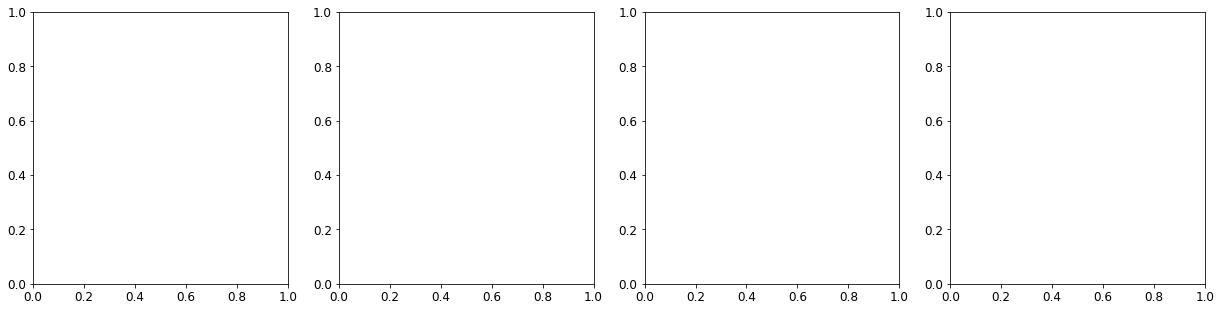

In [7]:
fig, ax = plt.subplots(ncols = 4, figsize = (21,5))

col_list = [0, 1, 2, 3]
train_list = [train_nsga30, train_nsga31, train_nsga32, train_nsga33]
hvs_list = [hvs_nsga30, hvs_nsga31, hvs_nsga32, hvs_nsga33]
n_batch_list = [400, 200, 100, 50]
batch_size_list = [2, 4, 8, 16]

for i, train, hvs, n_batch, batch_size in zip(col_list, train_list, hvs_list, n_batch_list, batch_size_list):
    
    batch_number = torch.cat([torch.zeros(2*(problem.n_var+1)),
                          torch.arange(1, n_batch+1).repeat(batch_size, 1).t().reshape(-1)
                         ]).numpy()

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=5, marker=".", alpha=0.8)
    
    ax[i].scatter(-train[...,problem.n_var:problem.n_var+problem.n_obj][:,0],
                  -train[...,problem.n_var:problem.n_var+problem.n_obj][:,1],
                 c=batch_number, s=10, alpha=0.8)

    ax[i].scatter(ref_point.cpu().numpy()[0],
                  ref_point.cpu().numpy()[1], 
                  c="r", s=100, marker="*")
    
    ax[i].text(1.2, 0, f"HV = {hvs[-1]:.7f}\n({n_batch} x {batch_size})", fontsize=18)
    
    ax[i].set_xlabel('f1', fontsize=14)
    
    ax[i].set_xlim(-0.2, 3)
    ax[i].set_ylim(-0.2, 3)
    
ax[0].set_title(f"ZDT1 (d={dimensions}), MOEA U-NSGA-III", fontsize=18)
ax[0].set_ylabel('f2', fontsize=14)

fig.tight_layout()